In [11]:
import scipy.io
import os
import numpy as np
import builtins as bins
import cv2

In [14]:
def ResizeImage(imgPath):
    img = cv2.imread(imgPath)
    img = cv2.resize(img, dsize=(50, 50), interpolation=cv2.INTER_CUBIC)
    imgVec = img.reshape(1, 7500)
    return imgVec

mat = scipy.io.loadmat('subset.mat')
trainTest = mat['subset']

path_to_dataset = 'tiny-UCF101'
categories = sorted(os.listdir(path_to_dataset))
l = list(range(0, 102))
labelDict = dict(bins.zip(categories, l))

imgPaths = []
labels = []
directory1 = 'tiny-UCF101'

for directory2 in sorted(os.listdir(directory1)):
    # print(directory2)
    for fileName in sorted(os.listdir(os.path.join(directory1, directory2))):
        f = os.path.join(directory1, directory2, fileName)
        imgPaths.append(f)
        labels.append(labelDict[directory2])

trainX = np.zeros((1,7500))
testX = np.zeros((1,7500))
trainY = []
testY = []
for i in range(0, 13320):
    imgVec = ResizeImage(imgPaths[i])
    label = labels[i]
    if(trainTest[i] == 'training'):
        trainX = np.vstack([trainX, imgVec])
        trainY.append(label)
    else:
        testX = np.vstack([testX, imgVec])
        testY.append(label)

trainX = np.delete(trainX, 0, 0)
testX = np.delete(testX, 0, 0)
print(trainX.shape)
print(testX.shape)

(9537, 7500)
(3783, 7500)


###### Multinomial Logistic Regression

In [15]:
from scipy.special import softmax
from sklearn.preprocessing import OneHotEncoder
onehot_encoder = OneHotEncoder(sparse=False)
import pandas as pd
from sklearn.preprocessing import StandardScaler

In [16]:
def ComputeLoss(X, Y, W):
    Z = - X @ W
    N = X.shape[0]
    term = np.sum(np.log(np.sum(np.exp(Z), axis=1)))
    loss = 1/N * (np.trace(X @ W @ Y.T) + term)
    return loss

In [25]:
def FindGradient(X, Y, W):
    Z = - X @ W
    P = softmax(Z, axis=1)
    N = X.shape[0]
    gd = 1/N * np.matmul(X.T,(Y - P))
    return gd

In [26]:
def InitializeW(W):
    r = W.shape[0]
    c = W.shape[1]
    val = 0.1
    for i in range(0,r):
        W[i, :] = val
        if (val == 0.9):
            val = 0.1
        else:
            val += 0.1
    return W

In [27]:
def GD(X, Y, max_iter=1200, lr=0.05):
    Y_onehot = onehot_encoder.fit_transform(Y.reshape(-1, 1))
    W = np.zeros((X.shape[1], Y_onehot.shape[1]))
    # W = InitializeW(W)
    step = 0
    step1 = []
    loss = []
    Ws = []

    while step < max_iter:
        step += 1
        W = W - (lr * FindGradient(X, Y_onehot, W))
        step1.append(step)
        Ws.append(W)
        loss.append(ComputeLoss(X, Y_onehot, W))

    df = pd.DataFrame({
        'step': step1,
        'loss': loss
    })
    return df, W

In [28]:
class MultinomialLogisticRegression:
    def fit(self, X, Y):
        self.loss, self.W = GD(X, Y)

    def plotLoss(self):
        return self.loss.plot(
            x='step',
            y='loss',
            xlabel='step',
            ylabel='loss'
        )

    def predict(self, X):
        F = - X @ self.W
        P = softmax(F, axis=1)
        return np.argmax(P, axis=1)

(9537, 7500)


<AxesSubplot:xlabel='step', ylabel='loss'>

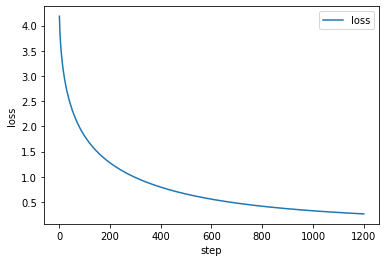

In [29]:
from sklearn.preprocessing import StandardScaler
# trainX = trainX[0:4000, :]
# trainY = np.array(trainY)
# trainY = trainY[0:4000,]

scaler = StandardScaler()
trainX = scaler.fit_transform(trainX)
# trainY = trainY.reshape(-1, 1)
# print(trainY.shape)
# trainY = scaler.transform(trainY)

print (trainX.shape)
trainY = np.array(trainY)

model = MultinomialLogisticRegression()
model.fit(trainX, trainY)
model.plotLoss()

In [30]:
model.W

array([[ 0.00252376,  0.00221801, -0.0059998 , ..., -0.00396324,
        -0.01072371, -0.00371828],
       [ 0.00448264,  0.00766536, -0.01316407, ...,  0.00189192,
        -0.01254926, -0.00365146],
       [ 0.00664977,  0.01480756, -0.00688157, ...,  0.00175147,
        -0.01344219, -0.0023824 ],
       ...,
       [-0.00535756,  0.00355609,  0.01106629, ...,  0.00137662,
         0.02703831,  0.01407238],
       [-0.0038961 ,  0.00463498, -0.00290561, ...,  0.00337726,
         0.02158637,  0.01193875],
       [ 0.00655198,  0.01033942,  0.00182482, ..., -0.00226183,
         0.00547268, -0.01036387]])

In [31]:
testX = scaler.fit_transform(testX)


In [33]:
# predResults = model.predict(testX)
count = 0
Z = - testX @ model.W
P = softmax(Z, axis=1)
ans = np.argmax(P, axis=1)

for i in range(0, 3783):
    if (ans[i] == testY[i]):
        count += 1
print(count)


603


In [100]:
count = 0
for i in range(0, 3783):
    if (predResults[i] == testY[i]):
        count += 1
print(count)

640


In [108]:
1280/3783

0.33835580227332807

### ROC Curve 50th Class

In [138]:
count =  (testY == 50).sum()
print(count)

39


In [139]:
test50Y = np.zeros((3783,))
preds50Y = np.zeros((3783,))
for i in range ( 0 , 3783):
    if(testY[i] == 50):
        test50Y[i] = 1
        if(ans[i] == 50):
            preds50Y[i] = 1

print(np.sum(preds50Y))



4.0


[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
0.5512820512820513


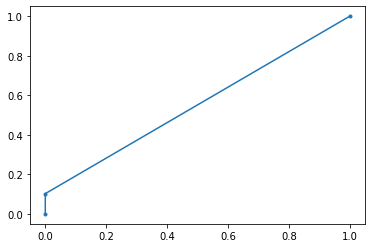

In [140]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, t = roc_curve(test50Y, preds50Y)

print(test50Y)
print(preds50Y)

auc = roc_auc_score(test50Y, preds50Y)
print(auc)

plt.plot(fpr, tpr, marker='.', label='Logistic')
plt.show()
